# Introduction



Two of the more exciting areas of growth in philosophy of science are large-scale automatic text analysis studies and cultural evolutionary models of scientific communities. Text analysis studies provide really useful ways of summarizing trends both in philosophy of science and the scientific literature. When we do intellectual history with classical methods, we tend to focus on the heavy hitting, widely cited papers. This makes good sense because people can only read so many papers in their short lives. So focus on the big ones. But most papers are not widely cited. They are just normal little contributions. These mundane papers get less attention in intellectual history. They tend to be boring. Understanding what ordinary work looks like is just as important for understanding a period as understanding the revolutionary papers. Machines don't get bored of reading mundane papers. Hence the appeal of automated text analysis.

Cultural evolutionary models imagine science is shaped by a process akin to natural selection. Some methods spread through the population of scientists. Others die out. If we could figure out the mechanisms that reward certain kinds of work, then selection-based models could provide some understanding of what shapes scientific practice in the long run.

A natural thought is that these two methods could be brought together. Text analysis provides the data to test, fit, or otherwise evaluate the cultural evolution models. So far, no one has been able to pull this off in a compelling manner. Rafael Ventura has an exciting new pre-print that is a good step in this direction. Ventura is looking at how formal methods have spread over time inside philosophy of science. The goal is to see whether there is any *selection* for model-based papers over other papers. In other words, is the incentive structure one that rewards modeling throughout philosophy of science?

His data collection has two steps. First, he organizes the published philosophy of science literature into 16 topics. The topics are based on co-citation networks. The intuitive picture (I'm no expert in bibliometric techniques so this is loose!) was that two papers that tend to cite the same references will tend to be in the same topic. If two papers cite a bunch of non-overlapping references, they will tend to be in different topics. Second, he classified papers by whether they used formal methods or not and tracked how the frequency of formal methods changes over time in the 16 topics. Full details on the data collection process are found here: http://philsci-archive.pitt.edu/20885/ . 

The bit that interests me is that choice to put papers into discrete topics based on co-citation. The 16 topics are not, of course, really entirely isolated research programs. Papers across the topics will cite some of the same works, experience some of the same incentive structures, and cultural shifts in one area of philosophy of science tend to diffuse into other areas. So the choice of 16 topics is somewhat artificial. This isn't to say it's a bad choice - there will definitely be a lot of cultural selection concentrated inside each topic. But the choice does introduce some limitations on the results. It would be nice if we could find a way around that, a way of quantifying the causal influence between research communities as well as within them. That's what this post is all about.

The past few months, I've been playing around with Bayesian statistical packages in Python. It is mostly just for curiosity's sake. But now when I read papers with data analysis and their underlying data is public, it can be a lot of fun to reanalyze the results. That's what I've done here. Specifically, I'm using a technique from Bayesian statistics called multi-level modeling.

The headline is that at least one of the major findings from Ventura's paper reverses when the same data is reanalyzed with multi-level modeling. He suggests that there is no selection for formal models across all of philosophy of science. But there might be selection for modeling within particular subdisciplines. I find a stronger pattern of selection for formal models at both levels - the whole of philosophy of science and the local clusters.

# The intuition behind multi-level modeling

Let's lay an intuition for multi-level modeling. Suppose you have a bag of red and blue marbles. If you pull out a sample of 10 marbles, you can estimate the proportion of blue marbles in the bag. This is a very standard statistical problem. Bayesians use examples like this to motivate their approach in intro books all the time. 

Now imagine you have a *big* bag containing 10 *small* bags of marbles. If you pull out 7 of the small bags and then you pull out 10 marbles from each bag, what's the right way of analyzing this data? 

- One option is to treat each bag as its own thing. It just the same problem as before but repeated 7 times. This approach seems silly because it assumes each small bag is entirely independent of the others. Surely, learning about the proportion of blue marbles in one bag should inform your expectation about the next bag because all of the small bags come from the same place.
- A second option is to ignore the fact marbles are grouped by little bags and just try to estimate the number of blue marbles in the big bag. You just count up the number of blue marbles across all bags and use that number to guide the estimate. This is also silly because you are ignoring the fact that the marbles are grouped by bag.

The best approach is to use multi-level modeling. You simultaneously try to estimate the proportion of marbles in each bag while also trying to estimate the amount that the bags are correlated. The big bag represents some underlying distributions that generates the small bags. If you could learn about the underlying distribution in the big bag, you could make smarter guesses as to what will happen in a given small bag.

Now replace bags with research communities. The big bag is the whole philosophy of science community. The little bags are the topic. At both levels, there is selection for or against formal methods. My goal is to estimate the selection in each topic while also allowing causal influence to flow between topics (and estimating how much cross-flow there is).

I'm not going to get too much further into the technical details. I imagine readers who know what I'm talking about will just want to see the code and readers who don't will need a specialized introduction to multi-level models. A really fun introduction to this strategy is here https://www.youtube.com/watch?v=SocRgsf202M. Onto the code.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az
import numpy as np
from scipy import stats

# Data cleaning

In [86]:
cluster_count_by_year = pd.read_csv("clusters_count_by_year.csv")
cluster_quant_count = pd.read_csv("clusters_quant_count_by_year.csv")
proportion_per_year = cluster_quant_count / cluster_count_by_year
proportion_per_year = proportion_per_year.drop(labels='CL',axis=1)

# 16 x 22 matrix

x = np.ones((16,21))

# fill each row with the numbers 0-20

x[0:16] = np.arange(21)

# assign data to n and k

n = cluster_count_by_year.values
k = cluster_quant_count.values

# skip first entry in each row
# which is just an index

k = k[:,1:]
n = n[:,1:]

# transpose all arrays
# my bayes stats package (pymc) 
# expects variables in
# column orientation

x = x.T
k = k.T
n = n.T

x.shape,k.shape,n.shape

((21, 16), (21, 16), (21, 16))

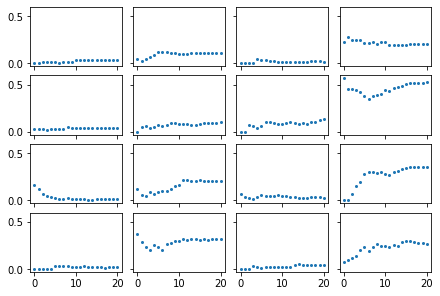

In [25]:
# construct a 4x4 grid of subplots
# one for each of 16 topics.

f,ax = plt.subplots(4,4,sharex=True,sharey=True,layout='constrained')

# loop through the grid and plot the proportion
# of formal papers for each year.

for i in range(4):
    for j in range(4):
        ax[i][j].plot(proportion_per_year.iloc[i*4+j].values,'o',markersize=2)

Here's what the data looks like for each of the 16 topics. Each dot represents the proportion of formal methods papers in a topic for a given year, starting at 2000 through 2020.

# Unpooled analysis

My real goal is a multi-level model (also called partial pooling). But to calibrate my expectations, I want to fit a simpler model without a multi-level structure. I'm just going to treat each topic as its own thing and estimate the trend in formal methods one at a time.

One difference between my analysis and Ventura's relies on how we specified our logistic regressions. He used a probit model whereas I used an logit model. The difference shouldn't matter (and is very esoteric anyway). I only picked a logit because it plays nicer with the bayesian software package. So we shouldn't get exactly the same results but the general conclusions should remain the same.

## Prior simulation

When working with Bayesian methods, we have to select priors. I used a strategy known as *weakly regularizing priors*. The goal is to pick out priors that penalize really extreme effects but still allow for enough uncertainty that the data can drive the ultimate analysis. To calibrate the priors before including the data, I sample from my prior distributions and plots 50 lines at a time to give me a sense of what plausible relationships might look like.

Below is the priors I ended up using. For the slopes, I assumed a normal distribution centered around 0 with a standard deviation of 0.3. For the intercepts, I assumed a normal distribution centered around 0 with a standard deviation of 3.

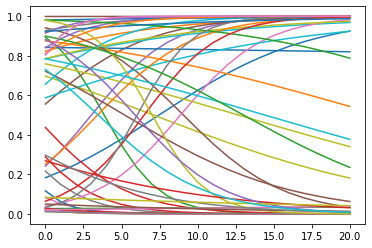

In [71]:
# prior simulation

x_prior = np.arange(21)

for i in range(50):
    
    # sample a value from the priors

    a = stats.norm(0,3).rvs()
    b = stats.norm(0,0.3).rvs()
    
    # plug into the inverse logit function

    p = np.exp(a + b*x_prior) / (1 + np.exp(a + b*x_prior))

    plt.plot(p)

Later, we'll find that my results depart from those found by Ventura in a couple of places. I suspect that is partly due to the influence of the priors. So I want to spend a bit longer justifying mine.

Many people are skeptical of the use of priors in statistics. Isn't it cheating to build assumptions into the model, rather than letting the data do the work? The trouble with prior skepticism is that all analyzes use priors, it's just that Bayesian analysis uses them explicitly. Other modeling techniques will often tacitly assume flat priors on the possible intercept and slopes. Let me show you what the models look like with much flatter priors.

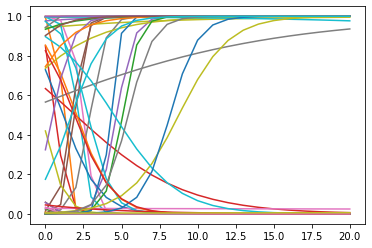

In [116]:
# prior simulation

x_prior = np.arange(21)

for i in range(50):

    a = stats.norm(0,5).rvs()
    b = stats.norm(0,2).rvs()

    p = np.exp(a + b*x_prior) / (1 + np.exp(a + b*x_prior))

    plt.plot(p)

Here I expanded the standard of deviation around the intercept and the slope. The irony is that increasing uncertainty at the level of the priors can decrease uncertainty at the level of predictions. Most predicted models here assume really sharp slopes and implausibly faster growth rates for formal methods in philosophy. Most of these lines shoot from the top to the bottom in the span of 5 or 6 years, suggesting that philosophy could have made a complete revolution in methodology. These predictions are implausible. (A careful explanation of why non-informative priors can be problematic can be found in Richard McElreath's statistical rethinking book https://xcelab.net/rm/statistical-rethinking/). Hence my preference for the weakly informative priors described above. 

## Sampling

This code fits 16 logistic regressions, one for each topic.

In [73]:
with pm.Model() as no_pool:
    
    # priors
    
    a = pm.Normal('a',0,3,shape=16)
    b = pm.Normal('b',0,0.3,shape=16)
    
    # link function

    p = pm.invlogit(a + b*x)
    
    # outcome distribution

    y = pm.Binomial('y',p=p,n=n,observed=k)
    
    # sampler
    
    trace_no_pool = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, b]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 122 seconds.


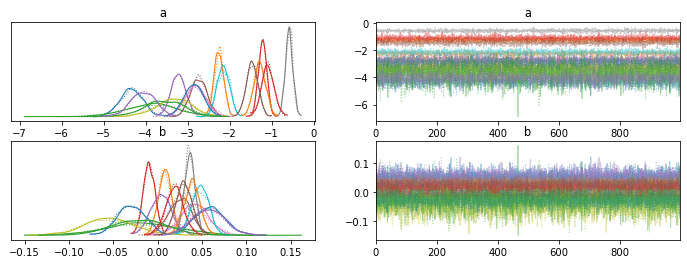

In [78]:
az.plot_trace(trace_no_pool);

These plots provide a check on whether the computational estimation strategy was effective. There is little to discuss here, a good sign that nothing blew up during sampling.

In [79]:
az.summary(trace_no_pool)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a[0],-4.338,0.271,-4.848,-3.839,0.004,0.003,4053.0,1686.0,1.00
a[1],-2.255,0.114,-2.464,-2.038,0.002,0.001,3221.0,1556.0,1.00
a[2],-3.873,0.606,-4.960,-2.704,0.010,0.008,3750.0,1148.0,1.01
a[3],-1.214,0.097,-1.390,-1.030,0.002,0.001,3046.0,1431.0,1.00
a[4],-3.228,0.175,-3.558,-2.900,0.003,0.002,3156.0,1404.0,1.00
a[5],-2.739,0.190,-3.103,-2.398,0.004,0.003,2579.0,1502.0,1.00
a[6],-2.807,0.261,-3.323,-2.326,0.005,0.003,2981.0,1315.0,1.00
a[7],-0.582,0.088,-0.743,-0.413,0.002,0.001,2781.0,1632.0,1.00
a[8],-3.334,0.429,-4.166,-2.550,0.007,0.005,3857.0,1710.0,1.00
a[9],-2.150,0.151,-2.417,-1.870,0.003,0.002,2659.0,1498.0,1.00


This table has loads of information in it. I report it mostly for transparency. A more accessible display of information is the forest plot below.

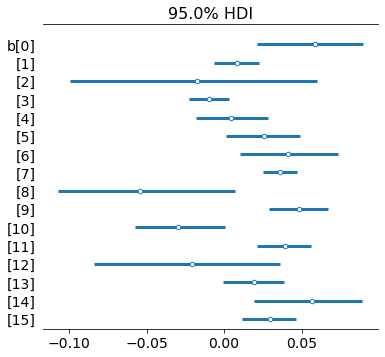

In [80]:
az.plot_forest(trace_no_pool,var_names='b',combined=True,hdi_prob=0.95,quartiles=False);

I'm just listing the slope parameters on each regression (ignoring the intercepts for now). Dots represent the highest posterior point estimate for each slope or, simply, the slope of best fit. The lines represent uncertainty - 95% of the posterior distribution fits within the line. This is like a 95% confidence interval in classic statistics.

The general pattern is that most topics experience a modest growth trend for formal methods. A few don't: Confirmation (2), Metaphysics (8), Relativity (10), and Realism (12). (The numbers that index topics in Ventura's paper and my analysis will be slightly different. I count up from 0 and go through 15. He counts from 1 and goes to 16. I do this just because the Bayesian fitting software uses this convention. So if you are switching between papers, just keep this in mind.)

## Posterior predictive checking

These numbers are hard to interpret just as numbers. Let's extract predictions from what the estimated models and compare them against the observed data.

In [81]:
post_pred_no_pool = pm.sample_posterior_predictive(trace_no_pool,model=no_pool)

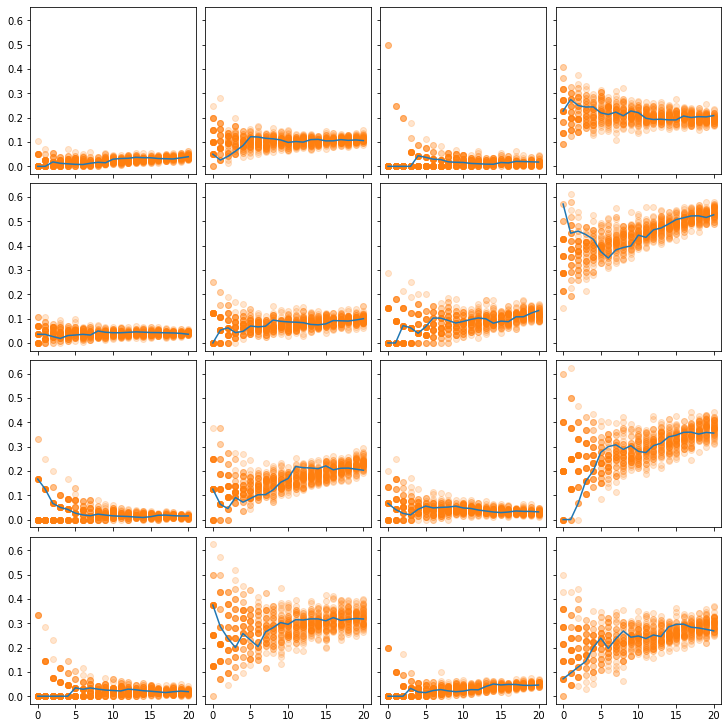

In [82]:
f,ax = plt.subplots(4,4,sharex=True,sharey=True,layout='constrained',figsize=(10,10))

for k in range(50):
    predictions = np.array(post_pred_no_pool.posterior_predictive.y[0][k].T)
    ceiling = n.T
    
    for i in range(4):
        for j in range(4):
            
            proportions = predictions[i*4+j] / ceiling[i*4+j]
            ax[i][j].plot(proportions,'o',alpha=0.2,color='tab:orange')
            
for i in range(4):
    for j in range(4):
        ax[i][j].plot(proportion_per_year.iloc[i*4+j].values,'-',markersize=2)

This plot displays the predicted proportion of formal papers in each year. Uncertainty is represented by the spread of the dots and their opacity.

One good check is whether the model captures a few plausible intuitive stories. For example, topic 11 is on row 3, column 4. It experiences huge growth in formal methods. This is decision theory. So it makes good sense that nearly half of papers published in this area are in the business of building models. (The other half are likely papers reflecting on the methodology or concepts of decision theory.)

One thing to notice is that uncertainty at the beginning of the period tends to be pretty large. This makes sense because we have very little data for the beginning of each period. Some of these topics only have a handful of papers published in them in the year 2000. So it's like the sample size is very small for the beginning. But it tends to grow in the later years so the estimate clamps down.

The high beginning uncertainty is also a reason why splitting the community into 16 topics might introduce some artifacts into the statistical analysis. In the year 2000, each subtopic was not as clearly distinguished as they were in, say, 2010. The common narrative is that philosophy of science sorta splintered into many sub-specialties at the end of the very end of the 20th century and then these subdisciplines consolidated during the early 2000s. So we should also expect more overlap in causal selective forces for the early years, something not reflected in this analysis. Instead, we get big initial uncertainty because each subtopic is not well-established yet.

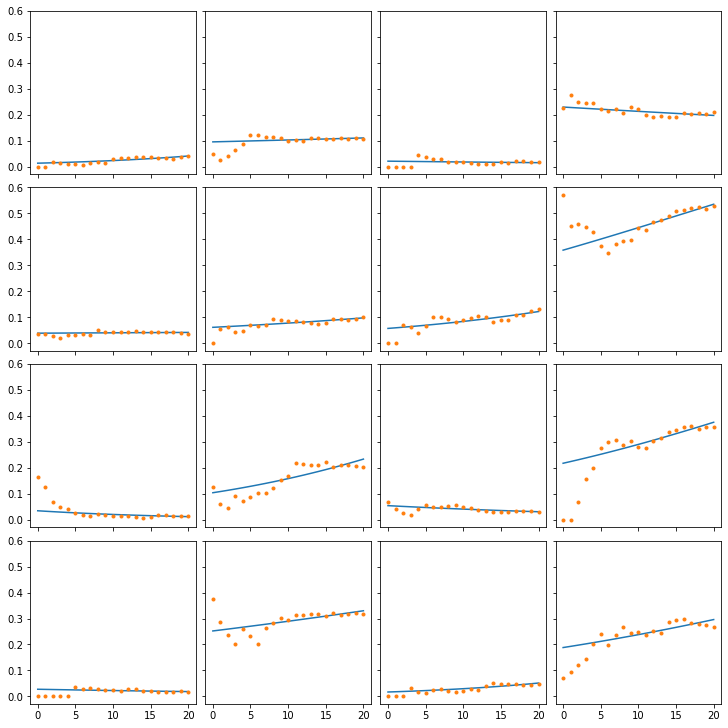

In [106]:
a_means = [np.array(trace_no_pool.posterior['a'][0][:,i].mean()) for i in range(16)]
b_means = [np.array(trace_no_pool.posterior['b'][0][:,i].mean()) for i in range(16)]
a_means = np.array(a_means)
b_means = np.array(b_means)

f,ax = plt.subplots(4,4,sharex=True,sharey=True,layout='constrained',figsize=(10,10))

x_pred = np.arange(21)

for i in range(4):
    for j in range(4):
        a = a_means[i*4+j] 
        b = b_means[i*4+j]
        p = np.exp(a + b*x_pred) / (1 + np.exp(a + b*x_pred))
        ax[i][j].plot(p)
        ax[i][j].plot(proportion_per_year.iloc[i*4+j].values,'o',markersize=3)

A second way of visualizing the model is to strip away the uncertainty and plot the best performing logistic curves for each community. These are what the model thinks the likely trend is in each place.

# Multi-level model analysis

Now time for the real focus.

## Prior simulation

Again I conduct a prior simulation. This time is tricker though because I have priors representing the overall population effects and the those priors shape the subsequent topic effects. So we want to get a prior simulation that allows for a wide range of possible population-topic relationships plus the old goal of giving each topic a range of plausible effects.

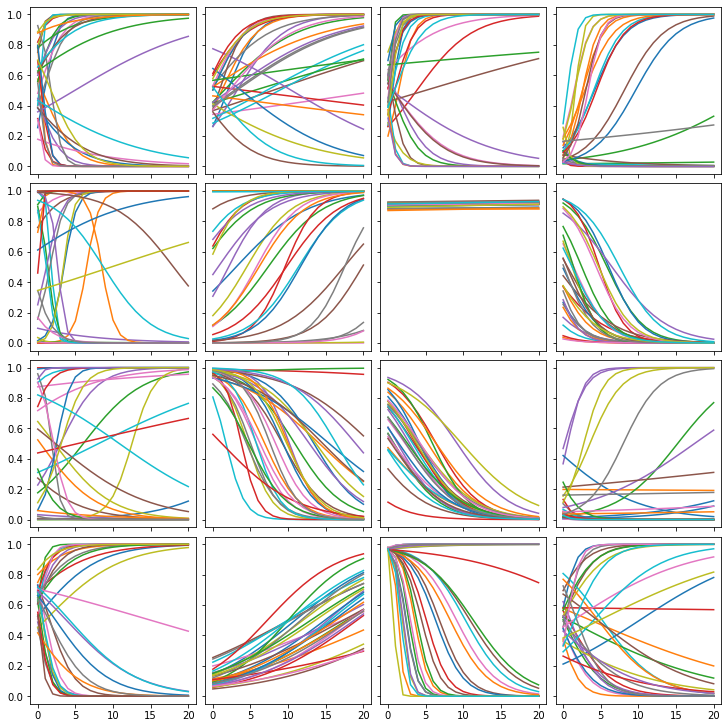

In [85]:
# prior simulation

f,ax = plt.subplots(4,4,sharex=True,sharey=True,layout='constrained',figsize=(10,10))

hamu = stats.norm(0,2).rvs(16)
hasig = stats.expon(scale=2).rvs(16)
hbmu = stats.norm(0,0.2).rvs(16)
hbsig = stats.expon(scale=0.7).rvs(16)

x_prior = np.arange(21)

for i in range(4): 
    for j in range(4):
        
        amu = hamu[i*4+j]
        asig = hasig[i*4+j]
        bmu = hbmu[i*4+j]
        bsig = hbsig[i*4+j]
        
        for k in range(30):

            a = stats.norm(amu,asig).rvs()
            b = stats.norm(bmu,bsig).rvs()

            p = np.exp(a + b*x_prior) / (1 + np.exp(a + b*x_prior))

            ax[i][j].plot(p)
        

## Sampling

In [87]:
with pm.Model() as partial_pool:
    
    # hyperparameters
    
    hamu = pm.Normal('hamu',0,2)
    hasig = pm.Exponential('hasig',2)
    hbmu = pm.Normal('hbmu',0,0.2)
    hbsig = pm.Exponential('hbsig',0.7)
    
    # regular parameters

    a = pm.Normal('a',hamu,hasig,shape=16)
    b = pm.Normal('b',hbmu,hbsig,shape=16)
    
    # link function

    p = pm.invlogit(a + b*x)
    
    # outcome distribution

    y = pm.Binomial('y',p=p,n=n,observed=k)
    
    # sampler
    
    trace_partial_pool = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [hamu, hasig, hbmu, hbsig, a, b]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 145 seconds.


In [117]:
az.summary(trace_partial_pool,hdi_prob=0.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
hamu,-2.523,0.313,-3.128,-1.902,0.006,0.004,3256.0,1252.0,1.00
hbmu,0.018,0.008,0.002,0.034,0.000,0.000,2644.0,1572.0,1.00
a[0],-4.105,0.223,-4.521,-3.662,0.004,0.003,3512.0,1260.0,1.00
a[1],-2.266,0.101,-2.449,-2.059,0.002,0.001,3104.0,1787.0,1.00
a[2],-4.092,0.378,-4.770,-3.313,0.007,0.005,2637.0,1439.0,1.00
a[3],-1.246,0.095,-1.422,-1.057,0.002,0.001,3484.0,1320.0,1.00
a[4],-3.260,0.165,-3.605,-2.966,0.003,0.002,3396.0,1405.0,1.00
a[5],-2.721,0.167,-3.079,-2.414,0.003,0.002,3159.0,1368.0,1.00
a[6],-2.715,0.234,-3.169,-2.259,0.004,0.003,2973.0,1485.0,1.00
a[7],-0.580,0.082,-0.752,-0.431,0.001,0.001,3395.0,1452.0,1.00


Let's compare the slopes estimated with multi-level models with those estimated by 16 independent models.

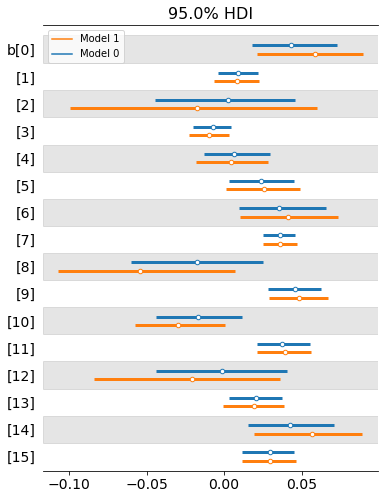

In [90]:
az.plot_forest([trace_partial_pool,trace_no_pool],var_names='b',combined=True,hdi_prob=0.95,quartiles=False);

One thing to notice is that the level of uncertainty has shrunk across the board. In basically every place, the blue line (multi-level / partial pooling) is shorter than the orange line (no pooling). This is because multi-level models can use more information to inform the estimate in each topic. Information is pooled across topics to form better expectations about each individual topic. It's like we've increased our sample size but we never had to collect new data. We just had to use it more efficiently.

A second thing to notice is that that several topics either switched from a negative to positive slope or they moved closer to positivity. This suggests that the multi-level model is detecting even stronger selection for formal methods than the previous analysis is. Why would this be? I suspect it largely depends on the interaction effect between intercepts and slopes. When the intercept starts really low, we are more likely to estimate a positive slope. When the intercept starts higher up, we are more likely to estimate a neutral or negative slope. The multi-level model now starts most intercepts fairly low. Here's a comparison of the two estimates by intercept. The blue lines tend to be more starkly negative for topics 2, 8 and 12, allowing their slopes to head toward positivity.

I plot the intercept comparisons below.

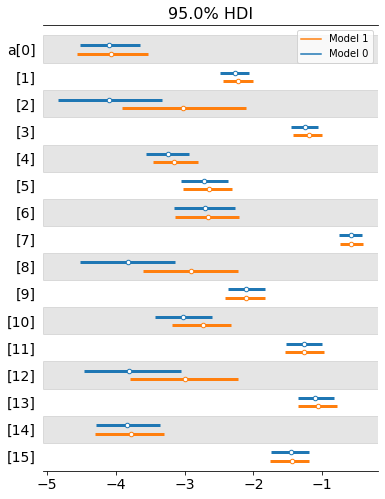

In [65]:
az.plot_forest([trace_partial_pool,trace_no_pool],var_names='a',combined=True,hdi_prob=0.95,quartiles=False);

## Posterior predictive checking

Let's look at the prediction plots now and see what changed once we introduced partial pooling.

In [92]:
post_pred_partial_pool = pm.sample_posterior_predictive(trace_partial_pool,model=partial_pool)

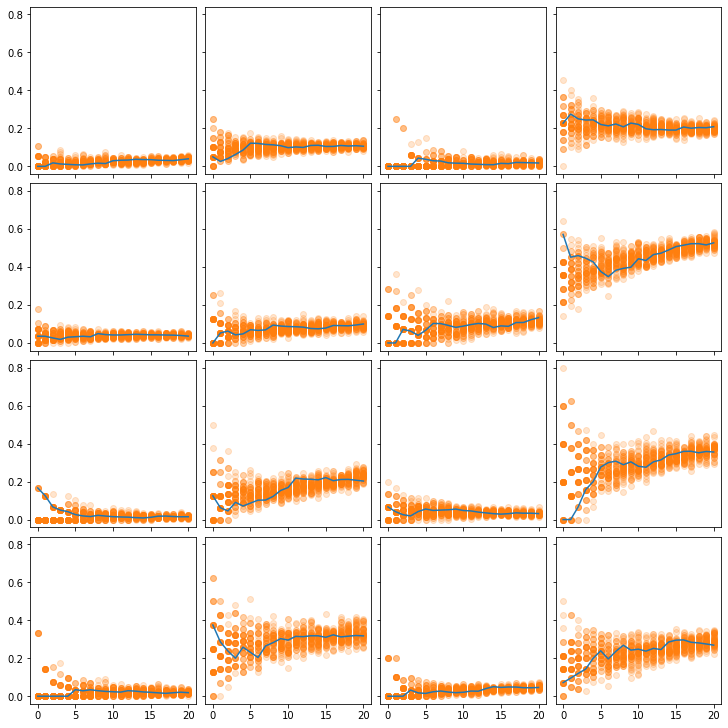

In [93]:
f,ax = plt.subplots(4,4,sharex=True,sharey=True,layout='constrained',figsize=(10,10))

for k in range(50):
    predictions = np.array(post_pred_partial_pool.posterior_predictive.y[0][k].T)
    ceiling = n.T
    
    for i in range(4):
        for j in range(4):
            
            proportions = predictions[i*4+j] / ceiling[i*4+j]
            ax[i][j].plot(proportions,'o',alpha=0.2,color='tab:orange')
            
for i in range(4):
    for j in range(4):
        ax[i][j].plot(proportion_per_year.iloc[i*4+j].values,'-',markersize=2)

One thing to notice that there is less initial uncertainty in many of these plots. This highlights on the advantages of multi-level models - less uncertainty in the intercepts means more plausible estimates of the slope.

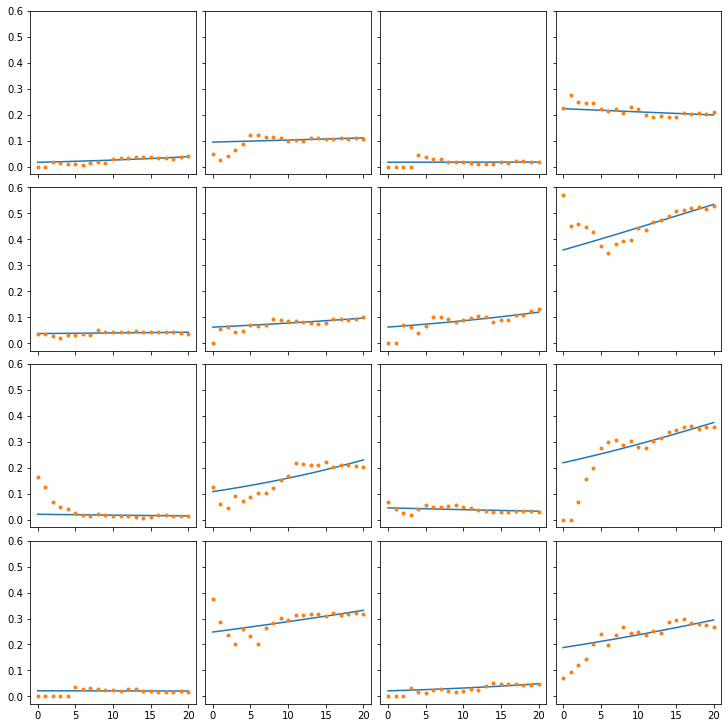

In [107]:
a_means_pp = [np.array(trace_partial_pool.posterior['a'][0][:,i].mean()) for i in range(16)]
b_means_pp = [np.array(trace_partial_pool.posterior['b'][0][:,i].mean()) for i in range(16)]
a_means_pp = np.array(a_means_pp)
b_means_pp = np.array(b_means_pp)

f,ax = plt.subplots(4,4,sharex=True,sharey=True,layout='constrained',figsize=(10,10))

x_pred = np.arange(21)

for i in range(4):
    for j in range(4):
        a = a_means_pp[i*4+j] 
        b = b_means_pp[i*4+j]
        p = np.exp(a + b*x_pred) / (1 + np.exp(a + b*x_pred))
        ax[i][j].plot(p)
        ax[i][j].plot(proportion_per_year.iloc[i*4+j].values,'o',markersize=3)

There are small divergences in the trend lines. I'll zoom in one difference in the last section.

Finally, we have the trend line for the entire population of studies. It is subtly but confidently positive, suggesting an overall tendency to select for formal methods in philosophy of science over the last several years. The observed trends are plotted and faded behind it.

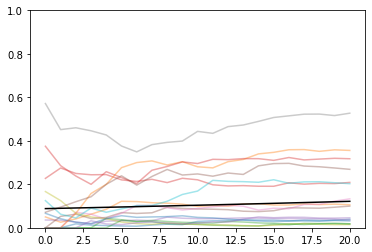

In [22]:
a = np.array(trace_partial_pool.posterior['hamu'].mean(("chain","draw")))
b = np.array(trace_partial_pool.posterior['hbmu'].mean(("chain","draw")))

p = np.exp(a + b*x_pred) / (1 + np.exp(a + b*x_pred))

for i in range(4):
    for j in range(4):
        plt.plot(proportion_per_year.iloc[i*4+j].values,'-',alpha=0.4)

plt.plot(p,color="black")
plt.ylim([0,1]);

Ventura's analysis noted that there was no overall selection for formal methods across philosophy of science. Interestingly, my analysis finds a small and very confident positive slope for the population-level effect. The population-level slope is 0.018 with the bottom of the credibility interval at 0.002 and the top at 0.034. So under classical statistics, this would be like a statistically significant effect. 

Should we prefer the multi-level trend estimate? I suspect so but the reason lies in how multi-level models handle each individual cluster. So I'll turn to that next.

# Comparing partial pooling and unpooled analysis

I want to provide one more illustration of why multi-level models are really helpful in this context. This time, we'll zoom in one one particular topic and study how the two different modeling strategies handle it. Consider topic 8 (metaphysics). When I first estimated this cluster with the unpooled model, the slope was solidly negative. The mean was -0.054 and the edges of the credibility interval were also mostly negative. But when we estimated the partially pooled model, the slope switched to -0.018 and the credibility interval that includes negative and positive values. Meanwhile, the intercept moved around too, from -3.3 to -3.8. The plot below illustrates what these look like along side the data.

old intercept: -3.3276601317057914
new intercept: -3.832830086819906
old slope: -0.05396677018935991
new slope: -0.01799343052745601


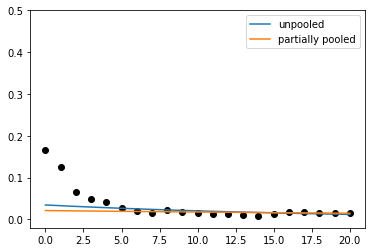

In [113]:
cluster = 8

# load relevant subset of data

quant_count_cluster = cluster_quant_count.iloc[cluster][1:].values
total_count_cluster = cluster_count_by_year.iloc[cluster][1:].values
plt.plot(quant_count_cluster / total_count_cluster,'o',color='black')

# load model parameters

plt.plot(np.exp(a_means[cluster] +  b_means[cluster]*x_pred) / (1 + np.exp(a_means[cluster] +  b_means[cluster]*x_pred)),label="unpooled")
plt.plot(np.exp(a_means_pp[cluster] +  b_means_pp[cluster]*x_pred) / (1 + np.exp(a_means_pp[cluster] +  b_means_pp[cluster]*x_pred)),label="partially pooled")
plt.legend()
plt.ylim([-0.02,0.5]);

print("old intercept:",a_means[cluster])
print("new intercept:",a_means_pp[cluster]) 
print("old slope:",b_means[cluster])
print("new slope:",b_means_pp[cluster])

On first glance, the partially pooled model does worse. Both models fit the data after 2005 just fine. But the unpooled model accommodates the starting points better. So why prefer the multi-level model?

One of the basic goals of regression is to help us distinguish between anomalous features of the data and regular ones. Regular features are supposed to represent some underlying causal pattern. Anomalous features represent random noise that is not a part of the underlying pattern. But how do you decide what is an anomaly and what is a pattern? The modeling assumptions are what makes those decisions.

Now here's the question, are the data points before 2005 an anomaly or part of our pattern? The multi-level model and the unpooled model make different decisions on this question. The unpooled model tries to accommodate them. The multi-level model basically ignores them. The reason the multi-level model ignores them is because it can see all the other topics as well and draw information from them. One thing it learns from studying the other models is that it is very rare for a topic to have a high initial intercept. So when it approaches this topic, it is skeptical of high intercept parameters. It confidently starts low and then sets the slope parameter wherever it needs to get a good match on the remaining data.

The unpooled model has less information for starting points so it sets it's slope parameter higher and then picks a negative slope to try to accommodate the later years.

Why then should we prefer the multi-level model in the end? It probably fits each individual cluster a bit worse than the unpooled model. But it uses the total sum of the information more efficiently because pay attention to the population-subpopulation structure. So we should expect the multi-level model is picking out the underlying pattern with more accuracy. Once it gets the intercepts low across the board, it can latch onto more positive slopes, too. If the slope estimates turn more positive for each cluster, then the overall trend has a better estimate too.